In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import glob

In [3]:
#hyperparameters
in_channel=3
num_classes=38
learning_rate=0.01
batch_size=32
num_epochs=20
sz=128

In [4]:
training_dir = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
validation_dir = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir= '../input/new-plant-diseases-dataset/test'


In [5]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz,sz)),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_ds = datasets.ImageFolder(training_dir, train_transforms)
valid_ds = datasets.ImageFolder(validation_dir, valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)


In [6]:
#load pretrained model and modify it 
model=torchvision.models.MobileNetV2()
#print(model)


In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
   
    def forward(self,x):
        return x

In [8]:
model.classifier=nn.Sequential(nn.Linear(1280,500),
                               nn.ReLU(), 
                               nn.Linear(500,38))

for the mobilenet, in order to set the output as the same as our number of classes, we have to change the fully connected layer which is 1000 neurons to 38 neurons we used the following commands:
model.classifier=nn.Sequential(nn.Linear(1280,500),
                               nn.ReLU(), 
                               nn.Linear(500,38))


In [ ]:
print(model)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def model_eval(model, data_loader ) :

 model.eval()
 with torch.no_grad(): 
     correct = 0
     total = 0
     for data in data_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy=(correct / total) * 100
 return accuracy


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)
acctrainlist=[]
accvalidlist=[]
num_epochs = 20
total_steps = len(train_dl)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(train_dl):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            val_accuracy=model_eval(model, valid_dl ) 
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100,val_accuracy))
            acctrainlist[int((i+1)/100)-1]=acctrainlist.append((correct / total) * 100)
            accvalidlist[int((i+1)/100)-1]=accvalidlist.append(val_accuracy)
             
   

    print("######## Training Finished in {} seconds ###########".format(time.time()-t1)) 


Device: cuda:0
Epoch [1/20], Step [100/2197], Loss: 3.6375, Accuracy: 3.12%, Validation Accuracy: 2.86%
Epoch [1/20], Step [200/2197], Loss: 3.6308, Accuracy: 6.25%, Validation Accuracy: 2.83%
Epoch [1/20], Step [300/2197], Loss: 3.6494, Accuracy: 0.00%, Validation Accuracy: 2.86%
Epoch [1/20], Step [400/2197], Loss: 3.6411, Accuracy: 3.12%, Validation Accuracy: 2.87%
Epoch [1/20], Step [500/2197], Loss: 3.6354, Accuracy: 0.00%, Validation Accuracy: 2.83%
Epoch [1/20], Step [600/2197], Loss: 3.6324, Accuracy: 6.25%, Validation Accuracy: 2.83%


KeyboardInterrupt: 

In [ ]:
# Save to file
 x = torch.tensor([0, 1, 2, 3, 4])
 torch.save(x, 'tensor.pt')

In [31]:
print(acctrainlist)

[]


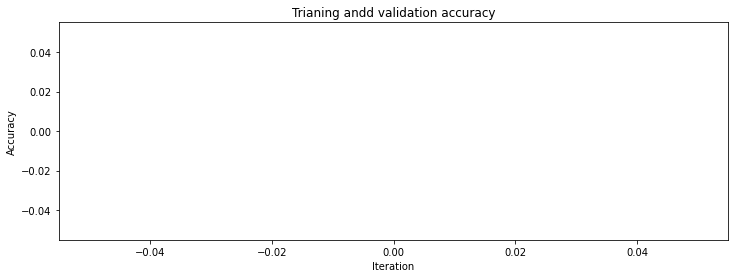

In [12]:
####### plot the the training accuracies here #########
plt.figure(figsize=(12, 4))
plt.plot(acctrainlist)
plt.plot(accvalidlist)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Trianing andd validation accuracy')
plt.show()